
# Machine learning project 1 regression on `Delays` dataset
## Predicting total delay upon arrival

### Authors:
- Ayetijhya Desmukhya 
- Assyl Salah


## Introduction


The dataset includes 1631327 observations in the training sample and 407832 in the test sample and the following columns:

- Weekday – Day of the week when the flight occurred (1 for Sunday, 7 for Saturday).
- Month_of_Year – The numerical month (1-12) when the flight took place.
- Day_of_Month – The day of the month (1-31) when the flight occurred.
- Scheduled_Departure_Time – The scheduled local time of flight departure.
- Scheduled_Arrival_Time – The scheduled local time of flight arrival.
- Marketing_Airline – The airline code under which the flight was marketed.
- Marketing_Airline_DOT_ID – Department of Transportation identifier for the marketing airline.
- Flight_Number – The number assigned to the flight by the operating airline.
- Origin_Airport_ID – Unique identifier for the departure airport.
- Destination_Airport_ID – Unique identifier for the arrival airport.
- Flight_Cancelled – Indicator of whether the flight was cancelled (1 = Yes, 0 = No).
- Departure_State – The state code of the departure location.
- Arrival_State – The state code of the arrival location.
- Departure_Delay – Total delay in minutes at departure.
- Diverted_Airport_Landings – Count of unplanned landings at other airports.
- Taxi_Out_Time – Time in minutes from gate departure until takeoff.
- Taxi_In_Time – Time in minutes from landing to gate arrival.
- Flight_Diverted – Indicator of whether the flight was diverted (1 = Yes, 0 = No).
- Actual_Departure_Time – The actual local time the flight departed.
- Flight_Duration – The duration of the flight in minutes from takeoff to landing.
- Flight_Distance – The total distance covered by the flight in miles.
- Origin_Temperature – The temperature at the origin airport at the time of the flight’s departure.
- Destination_Temperature – The temperature at the destination airport at the time of the flight’s arrival.
- Origin_Wind_Speed – The wind speed at the origin airport during the departure of the flight.
- Destination_Wind_Speed – The wind speed at the destination airport during the departure of the flight.
- Origin_Precipitation – The amount of precipitation, such as rain or snow, at the origin airport around the flight’s departure time.
- Destination_Precipitation – The amount of precipitation, such as rain or snow, at the destination airport around the flight’s arrival time.
- Arrival_Delay – Total delay in minutes at arrival (outcome variable, only in the training sample)

### Problem Statement

The regression models will be assessed using the **Mean Absolute Percentage Error (MAPE)**, specifically focusing on predicting the total minutes of delay upon arrival. The objective is to create regression models capable of accurately forecasting the arrival delay in minutes using the provided features.

In [1]:
# Data preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scaling
from sklearn.preprocessing import StandardScaler

# Splitting train and validation dataset
from sklearn.model_selection import train_test_split

# Regression models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    ElasticNet
)
# Calculating MAPE
from sklearn.metrics import mean_absolute_percentage_error



# To zip files for uploading in github 
import gzip
import shutil
import os


Temporary convert csv files to gzip and read from it for github upload

In [2]:
def gzip_csv_files(input_files):
    for input_file in input_files:
        output_gzip = input_file + '.gz'
        with open(input_file, 'rb') as f_in:
            with gzip.open(output_gzip, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        # os.remove(input_file)

input_files = ['data/delays_test.csv', 'data/delays_train.csv']

gzip_csv_files(input_files)
print(f'Files {input_files} gzipped to {input_files}.gz')




Files ['data/delays_test.csv', 'data/delays_train.csv'] gzipped to ['data/delays_test.csv', 'data/delays_train.csv'].gz


In [5]:
def read_gzipped_csv(gzipped_csv_file):
    df = pd.read_csv(gzipped_csv_file, compression='gzip')
    return df

train_data = read_gzipped_csv('data/delays_train.csv.gz')
test_data = read_gzipped_csv('data/delays_test.csv.gz')


## Loading data

In [46]:
# train_data = pd.read_csv('data\delays_train.csv')
# test_data = pd.read_csv('data\delays_test.csv')

## Data overview 

### Train data 

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631327 entries, 0 to 1631326
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Weekday                    1631327 non-null  int64  
 1   Month_of_Year              1631327 non-null  int64  
 2   Day_of_Month               1631327 non-null  int64  
 3   Scheduled_Departure_Time   1631327 non-null  int64  
 4   Scheduled_Arrival_Time     1631327 non-null  int64  
 5   Marketing_Airline          1467776 non-null  object 
 6   Marketing_Airline_DOT_ID   1631327 non-null  int64  
 7   Flight_Number              1631327 non-null  int64  
 8   Origin_Airport_ID          1631327 non-null  int64  
 9   Destination_Airport_ID     1468233 non-null  float64
 10  Flight_Cancelled           1631327 non-null  bool   
 11  Departure_State            1631327 non-null  object 
 12  Arrival_State              1631327 non-null  object 
 13  Departure_De

In [8]:
train_data.head()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,...,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
0,6,6,25,1222,1444,B6,20409,520,10397,12478.0,...,False,1224.0,107.0,760.0,25.140220,19.357739,21.019808,15.452723,0.0,0.0
1,2,6,21,1216,1304,NaN,19805,6297,14107,15376.0,...,False,1216.0,23.0,110.0,13.279939,20.470690,18.045064,12.910265,0.0,0.0
2,3,1,5,1945,2055,DL,19790,4124,13487,13076.0,...,False,1945.0,36.0,119.0,17.816202,13.967273,21.606228,17.976362,0.0,0.1
3,2,3,22,700,924,AA,19805,1538,15624,11298.0,...,False,658.0,125.0,641.0,24.562566,14.509228,24.946489,22.630553,0.0,0.0
4,4,7,14,2130,2359,NaN,19930,1116,14747,12889.0,...,False,2133.0,130.0,867.0,8.817992,10.866812,17.426336,17.401007,0.0,0.0


In [9]:
round(train_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Weekday,1631327.0,4.01,2.01,1.00,2.00,4.00,6.00,7.00
Month_of_Year,1631327.0,4.08,2.00,1.00,2.00,4.00,6.00,7.00
Day_of_Month,1631327.0,15.72,8.76,1.00,8.00,16.00,23.00,31.00
Scheduled_Departure_Time,1631327.0,1329.79,490.39,1.00,915.00,1320.00,1735.00,2359.00
Scheduled_Arrival_Time,1631327.0,1486.05,518.65,1.00,1103.00,1512.00,1920.00,2359.00
Marketing_Airline_DOT_ID,1631327.0,19830.81,276.15,19393.00,19790.00,19805.00,19977.00,20436.00
Flight_Number,1631327.0,2561.29,1745.16,1.00,1106.00,2228.00,3874.00,9680.00
Origin_Airport_ID,1631327.0,12660.01,1522.94,10135.00,11292.00,12889.00,14027.00,16869.00
Destination_Airport_ID,1468233.0,12658.28,1521.78,10135.00,11292.00,12889.00,14027.00,16869.00
Departure_Delay,1424866.0,13.11,53.96,-78.33,-5.08,-1.57,10.71,7223.21


Based on the summary statistics, it is observed that the numerical variables have varying scales. While some variables have relatively small ranges (e.g., Origin_Precipitation), others have larger ranges (e.g., Flight_distance). Therefore, it is beneficial to scale the variables before applying regression to ensure that their magnitudes do not disproportionately influence the model's results.

In [50]:
train_data.isnull().sum()

Weekday                           0
Month_of_Year                     0
Day_of_Month                      0
Scheduled_Departure_Time          0
Scheduled_Arrival_Time            0
Marketing_Airline            163551
Marketing_Airline_DOT_ID          0
Flight_Number                     0
Origin_Airport_ID                 0
Destination_Airport_ID       163094
Flight_Cancelled                  0
Departure_State                   0
Arrival_State                     0
Departure_Delay              206461
Arrival_Delay                211306
Diverted_Airport_Landings         0
Taxi_Out_Time                 49225
Taxi_In_Time                  49867
Flight_Diverted                   0
Actual_Departure_Time         48326
Flight_Duration              211490
Flight_Distance              163190
Origin_Temperature           163190
Destination_Temperature      163190
Origin_Wind_Speed            211490
Destination_Wind_Speed       211490
Origin_Precipitation              0
Destination_Precipitation   

Based on the count of missing values in each variable, it can be seen that several variables have missing values, including Marketing_Airline, Destination_Airport_ID, Departure_Delay, Arrival_Delay, and so on. Therefore, it is necessary to consider data imputation techniques to fill in these missing values before applying regression models to ensure complete and reliable analysis.

## Correlation of the variables

In [51]:
train_data.corr()

,Weekday,Month_of_Year,Day_of_Month,Scheduled_Departure_Time,Scheduled_Arrival_Time,Marketing_Airline_DOT_ID,Flight_Number,Origin_Airport_ID,Destination_Airport_ID,Flight_Cancelled,...,Flight_Diverted,Actual_Departure_Time,Flight_Duration,Flight_Distance,Origin_Temperature,Destination_Temperature,Origin_Wind_Speed,Destination_Wind_Speed,Origin_Precipitation,Destination_Precipitation
Weekday,1.000000,0.013243,-0.007594,0.003738,0.003215,0.011544,0.012452,0.002541,0.003247,0.030611,...,0.001467,0.006271,0.008298,0.011967,0.003060,0.003540,0.006017,0.006182,0.000842,0.000204
Month_of_Year,0.013243,1.000000,0.014420,0.005844,-0.013736,-0.007917,-0.015734,0.000178,0.001109,-0.065382,...,0.008054,0.002574,-0.017356,-0.004662,-0.000613,-0.001299,-0.014227,-0.014180,0.000571,0.001677
Day_of_Month,-0.007594,0.014420,1.000000,0.001220,-0.000767,-0.000149,-0.007688,0.000272,0.000302,-0.040721,...,0.001773,-0.000768,-0.002740,-0.000409,0.000256,0.001237,-0.001821,-0.002608,0.000170,-0.000731
Scheduled_Departure_Time,0.003738,0.005844,0.001220,1.000000,0.685664,0.014671,-0.007926,-0.033808,0.026065,0.017350,...,0.001576,0.945442,-0.009313,-0.004287,-0.001106,-0.000391,-0.012757,-0.013232,-0.001109,0.000253
Scheduled_Arrival_Time,0.003215,-0.013736,-0.000767,0.685664,1.000000,0.015049,0.004366,-0.013219,0.017726,0.015521,...,0.007304,0.690090,0.026126,0.021554,0.005242,0.004676,0.022312,0.021913,-0.001887,-0.000205
Marketing_Airline_DOT_ID,0.011544,-0.007917,-0.000149,0.014671,0.015049,1.000000,-0.033197,0.002979,0.003961,0.021942,...,0.005029,0.005479,0.151510,0.139288,0.031766,0.031983,0.112102,0.111437,0.000726,0.000392
Flight_Number,0.012452,-0.015734,-0.007688,-0.007926,0.004366,-0.033197,1.000000,-0.030080,-0.052911,0.020725,...,0.002505,-0.005470,-0.369151,-0.386446,-0.088172,-0.089044,-0.266915,-0.267000,-0.000519,-0.000641
Origin_Airport_ID,0.002541,0.000178,0.000272,-0.033808,-0.013219,0.002979,-0.030080,1.000000,0.006123,-0.016199,...,0.001284,-0.034412,0.060483,0.078571,0.019676,0.018161,0.043937,0.043434,0.000018,0.001376
Destination_Airport_ID,0.003247,0.001109,0.000302,0.026065,0.017726,0.003961,-0.052911,0.006123,1.000000,-0.017126,...,-0.003200,0.025677,0.093780,0.078831,0.018547,0.018620,0.064262,0.064721,-0.000448,0.000635
Flight_Cancelled,0.030611,-0.065382,-0.040721,0.017350,0.015521,0.021942,0.020725,-0.016199,-0.017126,1.000000,...,-0.008839,0.010452,NaN,-0.013188,-0.005428,-0.002631,NaN,NaN,0.001079,0.000586


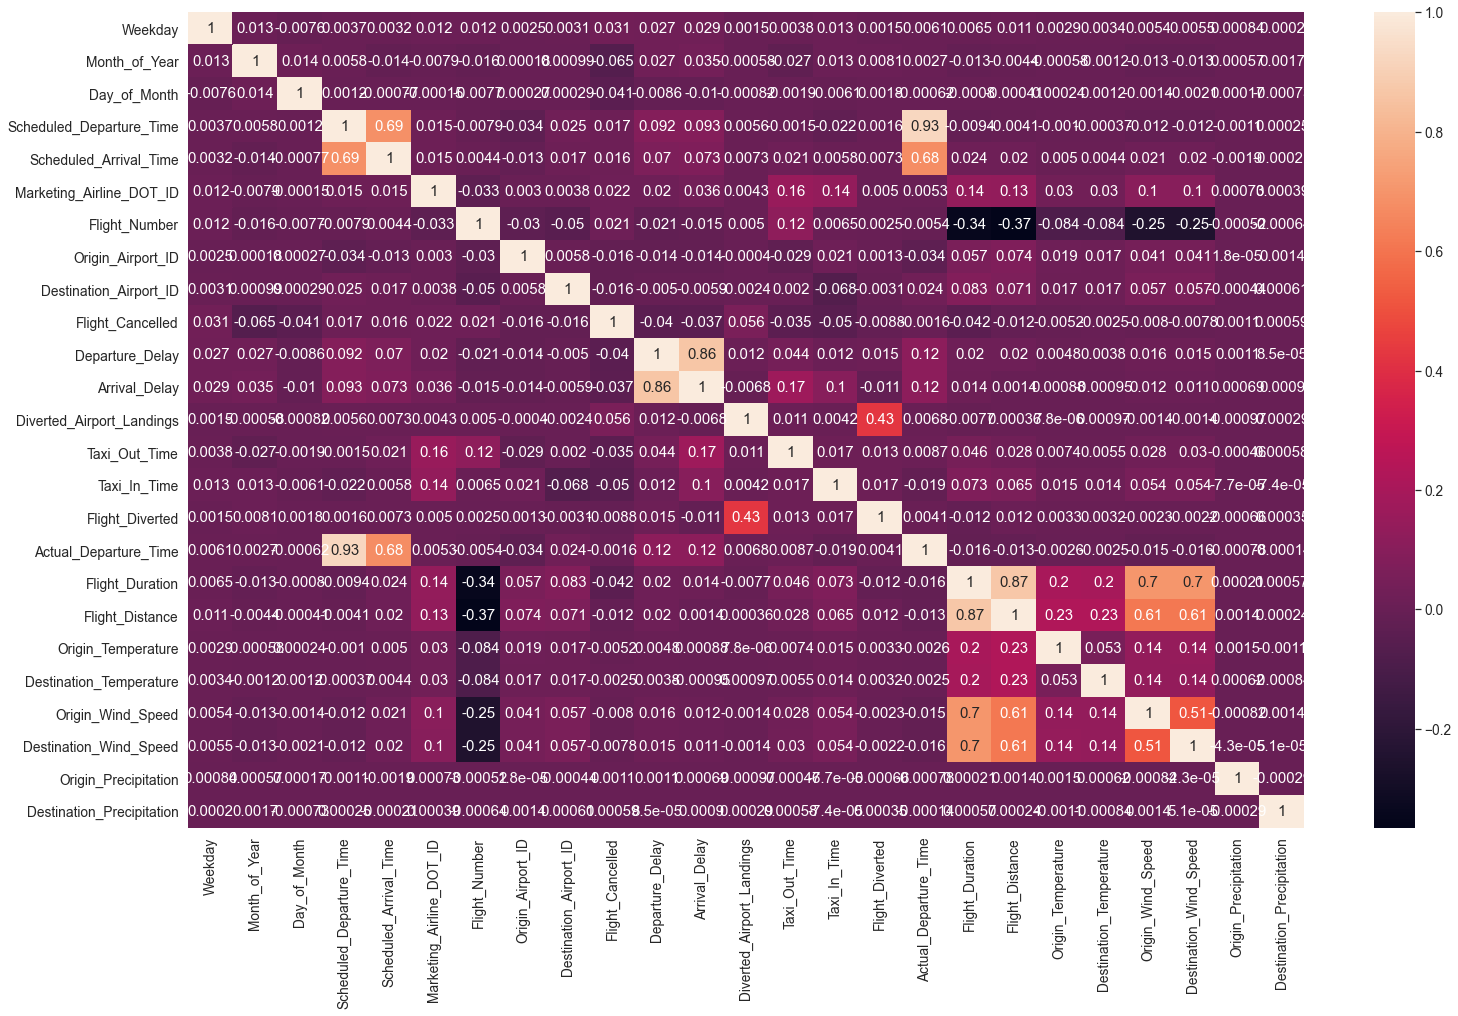

In [43]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.25)
sns.heatmap(train_data.corr(), annot=True) 
plt.show()


### Interpretation:

- Strong Positive Correlations:
Flight_Duration and Flight_Distance: There is a strong positive correlation (0.868) between flight duration and flight distance, which is expected since longer flights cover greater distances.


- Moderate Positive Correlations:
Scheduled_Departure_Time and Actual_Departure_Time: A moderate positive correlation (0.93) between scheduled and actual departure times indicates that flights tend to depart close to their scheduled times.
Marketing_Airline_DOT_ID and Flight_Number: A moderate positive correlation (0.14) between airline DOT IDs and flight numbers suggests some association between these identifiers.

- Weak Correlations:
Month_of_Year and Flight_Cancelled: There is a weak negative correlation (-0.065) between the month of the year and flight cancellations, suggesting that flight cancellations might vary slightly across different months.
Scheduled_Departure_Time and Day_of_Month: The correlation (0.001) between departure time and day of the month is very weak, indicating little relationship between these variables.

## Data preprocessing

In [36]:
train_data['Arrival_State'].unique()

array(['NY', 'AZ', 'WI', 'TX', 'NV', 'CA', 'PA', 'SD', 'AL', 'FL', 'KY',
       'WA', 'GA', 'OH', 'CO', 'ND', 'NJ', 'VA', 'PR', 'MO', 'MA', 'IL',
       'MD', 'HI', 'NC', 'UT', 'AK', 'AR', 'IN', 'LA', 'MI', 'MN', 'ME',
       'TN', 'OR', 'SC', 'NE', 'MT', 'VT', 'NM', 'CT', 'MS', 'RI', 'ID',
       'WY', 'IA', 'OK', 'WV', 'KS', 'VI', 'NH', 'TT', 'DE'], dtype=object)

In [37]:
train_data['Departure_State'].unique()

array(['GA', 'AZ', 'MN', 'FL', 'WA', 'CA', 'CO', 'IL', 'TX', 'TN', 'MA',
       'AR', 'PA', 'OR', 'NY', 'VA', 'VI', 'NC', 'UT', 'AK', 'SD', 'MI',
       'OH', 'NE', 'MO', 'OK', 'ME', 'NV', 'MD', 'KY', 'WI', 'NJ', 'IN',
       'LA', 'SC', 'HI', 'RI', 'PR', 'MS', 'AL', 'NH', 'MT', 'CT', 'ID',
       'WY', 'WV', 'NM', 'ND', 'IA', 'VT', 'KS', 'TT', 'DE'], dtype=object)

### Encoding

In [ ]:
# Encode categorical variables (one-hot encoding)
data_encoded = pd.get_dummies(train_data, columns=['Marketing_Airline', 'Departure_State', 'Arrival_State'])

### Data imputation

#### For numerical variables:
- Mean statistic globally was used to impute numerical variables


In [20]:
numeric_part_of_app_train = train_data.select_dtypes(['number'])
na_columns = numeric_part_of_app_train.columns[numeric_part_of_app_train.isna().any()].values.tolist()

for column in na_columns:
    train_data[column].fillna(train_data[column].median(), inplace=True)

#### For categorical data
- Filling missing data with unknown as new category

In [21]:
train_data['Marketing_Airline'].unique()

array(['B6', nan, 'DL', 'AA', 'WN', 'UA', 'G4', 'NK', 'AS', 'F9', 'HA'],
      dtype=object)

In [22]:
train_data['Marketing_Airline'].fillna('missing', inplace=True)

In [23]:
train_data.isnull().sum()

Weekday                      0
Month_of_Year                0
Day_of_Month                 0
Scheduled_Departure_Time     0
Scheduled_Arrival_Time       0
Marketing_Airline            0
Marketing_Airline_DOT_ID     0
Flight_Number                0
Origin_Airport_ID            0
Destination_Airport_ID       0
Flight_Cancelled             0
Departure_State              0
Arrival_State                0
Departure_Delay              0
Arrival_Delay                0
Diverted_Airport_Landings    0
Taxi_Out_Time                0
Taxi_In_Time                 0
Flight_Diverted              0
Actual_Departure_Time        0
Flight_Duration              0
Flight_Distance              0
Origin_Temperature           0
Destination_Temperature      0
Origin_Wind_Speed            0
Destination_Wind_Speed       0
Origin_Precipitation         0
Destination_Precipitation    0
dtype: int64

### Data visualization 

some histgram and box plot to check outliers and skewness?

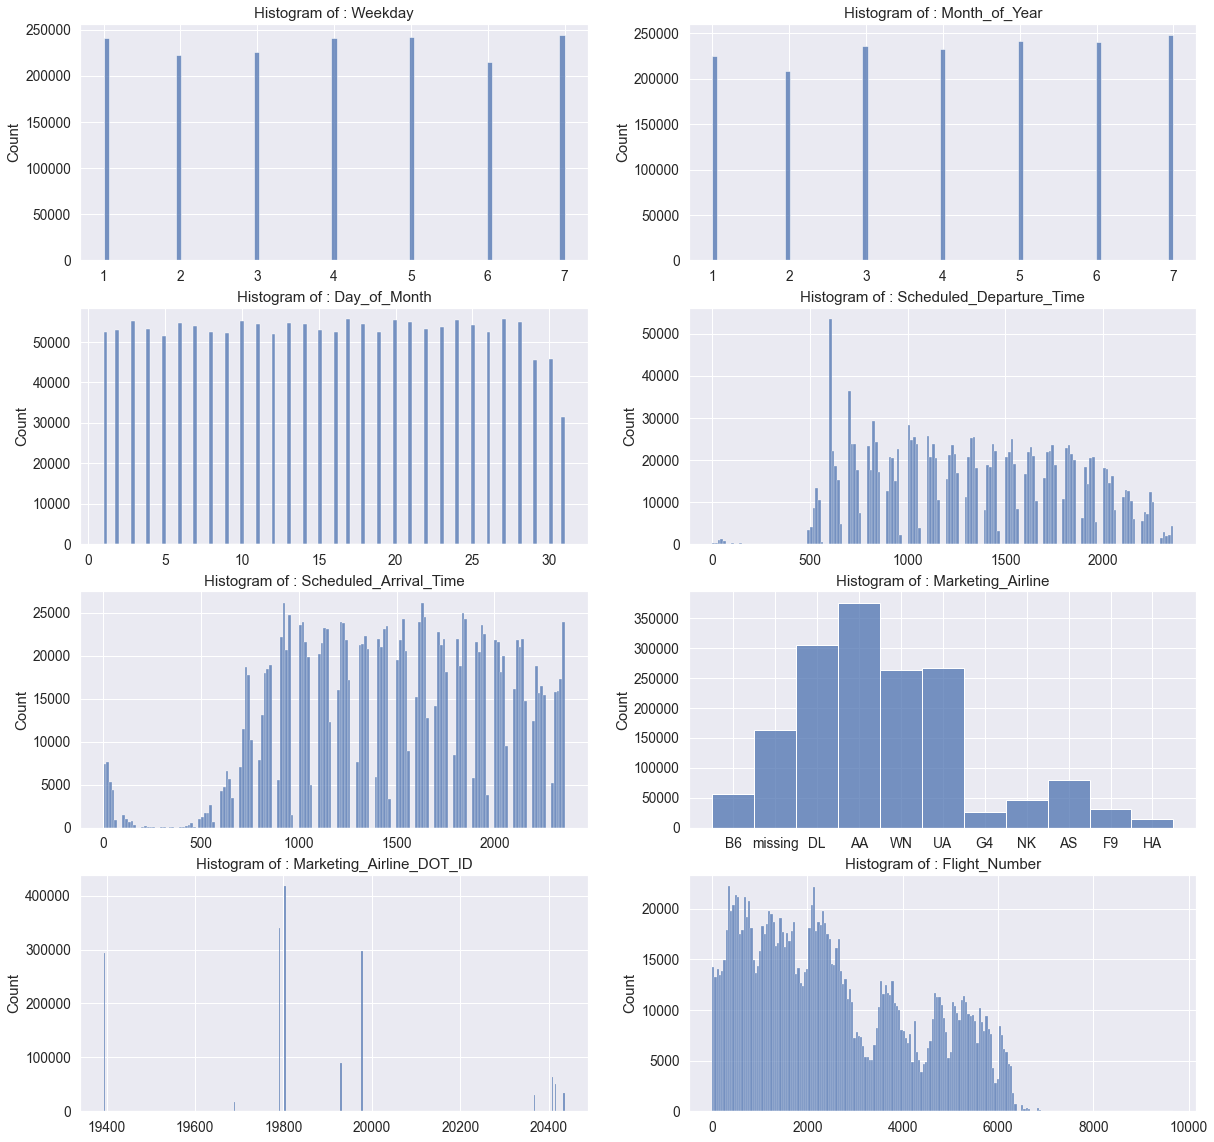

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
for i, ax in zip(train_data.columns, axes.flat):
    sns.histplot(x=train_data[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

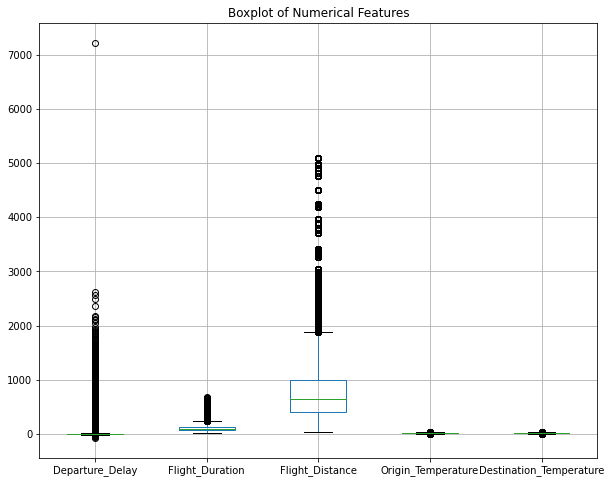

In [34]:
# Visualize box plots for selected numerical features
numerical_features = ['Departure_Delay', 'Flight_Duration', 'Flight_Distance', 
                      'Origin_Temperature', 'Destination_Temperature']
train_data[numerical_features].boxplot(figsize=(10, 8))
plt.title('Boxplot of Numerical Features')
plt.show()

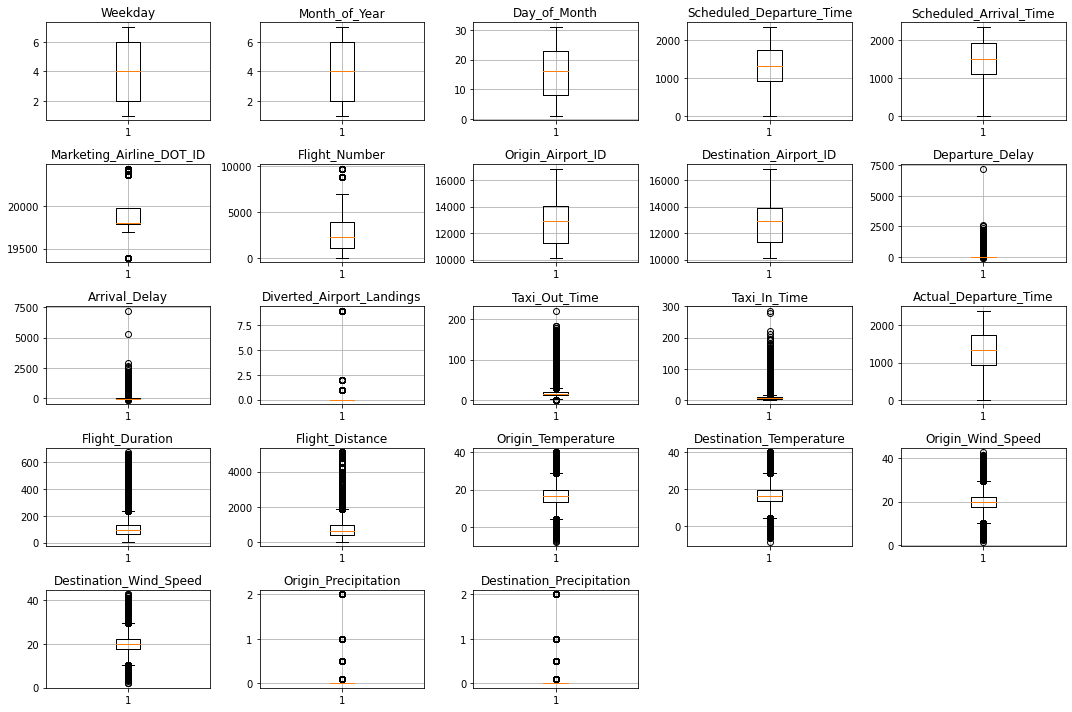

In [39]:
# Select only numerical columns for boxplot
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplots for each numerical column
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(5, 5, i)  # Adjust subplot layout based on the number of columns
    plt.boxplot(train_data[column])  # Plot boxplot for each column
    plt.title(column)  # Set title as column name
    plt.grid(True)  # Add grid for better visualization

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

### Removing outliers

### Scaling

In [ ]:
# Define the features for scaling
train_features = []


# Create a scaler and apply scaling
scaler = StandardScaler()
train_data[train_features] = scaler.fit_transform(train_data[train_features])

In [32]:
round(train_data.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Weekday,1631327.0,4.01,2.01,1.00,2.00,4.00,6.00,7.00
Month_of_Year,1631327.0,4.08,2.00,1.00,2.00,4.00,6.00,7.00
Day_of_Month,1631327.0,15.72,8.76,1.00,8.00,16.00,23.00,31.00
Scheduled_Departure_Time,1631327.0,1329.79,490.39,1.00,915.00,1320.00,1735.00,2359.00
Scheduled_Arrival_Time,1631327.0,1486.05,518.65,1.00,1103.00,1512.00,1920.00,2359.00
Marketing_Airline_DOT_ID,1631327.0,19830.81,276.15,19393.00,19790.00,19805.00,19977.00,20436.00
Flight_Number,1631327.0,2561.29,1745.16,1.00,1106.00,2228.00,3874.00,9680.00
Origin_Airport_ID,1631327.0,12660.01,1522.94,10135.00,11292.00,12889.00,14027.00,16869.00
Destination_Airport_ID,1631327.0,12681.35,1445.37,10135.00,11298.00,12889.00,13930.00,16869.00
Departure_Delay,1631327.0,11.26,50.66,-78.33,-4.84,-1.57,7.03,7223.21


## Regression models

We developed six distinct regression models to explore various regression algorithms.

- Initially, we split the training dataset into two subsets: 80% for training and 20% for validation. This division ensured distinct datasets for training and evaluating model performance.

- Each model was trained using the training dataset, where we fit them with the training features and corresponding target values. This process enabled the models to learn the underlying patterns and relationships within the data.

- Post-training, we utilized the validation features to generate predictions for the corresponding target values. By comparing these predictions with the actual target values in the validation set, we computed the Mean Absolute Percentage Error (MAPE) to evaluate model accuracy.

- Moreover, the code incorporates a step where the trained models were used to predict the target variable for the test dataset. These predictions were saved in distinct CSV files for each model.

Following these procedures allowed us to evaluate the performance of various linear regression models, identify the model with the lowest MAPE on the validation set, and generate predictions for the test dataset.

In [ ]:
# Define the features and target variable
features = ['']
target = 'Arrival_Delay'

# Split the data into training and validation sets
train_df, valid_df = train_test_split(train_data, test_size=0.2, random_state=123)

# Separate features and target for training, validation, and testing
X_train = train_df[features]
y_train = train_df[target]
X_valid = valid_df[features]
y_valid = valid_df[target]
X_test = test_data[features]

# Define the regression algorithms
algorithms = [
    LinearRegression(),
    Ridge(alpha=0.5, random_state=123),
    Lasso(alpha=0.5, random_state=123),
    RandomForestRegressor(n_estimators=150, max_depth=15, random_state=123),
    ElasticNet(alpha=0.5, l1_ratio=0.5),
    xgb.XGBRegressor()
]

# Iterate over the algorithms and print the MAPE results
for algorithm in algorithms:
    model_name = algorithm.__class__.__name__
    model = algorithm
    model.fit(X_train, y_train)
    val_predictions = model.predict(X_valid)
    mape = mean_absolute_percentage_error(y_valid, val_predictions)
    print(f"{model_name} MAPE on validation set: {mape * 100:.2f}%")
    
    # Predict test data and save the predictions as separate CSV files
    test_predictions = model.predict(X_test)
    
    # Create a DataFrame with the predictions
    predictions_df = pd.DataFrame({model_name: test_predictions})
    
    # Save the predictions to a CSV file
    predictions_df.to_csv(f'{model_name}_predictions.csv', index=False)

## Conclusion

## Refrences 